# Modelo Árboles de decisión y clasificación (CART) 

Referencia: https://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html

# Dataset: Heart Failure Prediction Dataset

## Descripción

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo y se cobran aproximadamente 17,9 millones de vidas cada año, lo que representa el 31 % de todas las muertes en todo el mundo. Cuatro de cada 5 muertes por ECV se deben a ataques cardíacos y accidentes cerebrovasculares, y un tercio de estas muertes ocurren prematuramente en personas menores de 70 años. La insuficiencia cardíaca es un evento común causado por ECV y este conjunto de datos contiene 11 características que pueden usarse para predecir una posible enfermedad cardíaca. Las personas con enfermedades cardiovasculares o que tienen un alto riesgo cardiovascular (por la presencia de uno o más factores de riesgo como hipertensión, diabetes, hiperlipidemia o enfermedad ya establecida) necesitan una detección y manejo temprano en el que un modelo de aprendizaje automático puede ser de gran ayuda.

# Cargar los datos

In [16]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [17]:
# https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
# Desarrollar el ejercicio propuesto implementando la regresión logística
datos = pd.read_csv('./heart.csv')

In [38]:
datos.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


Variables de interes:
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]

## Revisión de los datos

Se generará la tabla y los gráficos de los datos que vamos a analizar.

In [36]:
datos[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']].head(10)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,140,289,0,172,0.0,0
1,49,160,180,0,156,1.0,1
2,37,130,283,0,98,0.0,0
3,48,138,214,0,108,1.5,1
4,54,150,195,0,122,0.0,0
5,39,120,339,0,170,0.0,0
6,45,130,237,0,170,0.0,0
7,54,110,208,0,142,0.0,0
8,37,140,207,0,130,1.5,1
9,48,120,284,0,120,0.0,0


## Función logística

Se ajusta un árbol de clasificación empleando como variable respuesta `datos`  y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros `max_depth=5` y `criterion='gini'` , el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.

In [37]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'HeartDisease'),
                                        datos['HeartDisease'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [23]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                688 non-null    float64
 1   RestingBP          688 non-null    float64
 2   Cholesterol        688 non-null    float64
 3   FastingBS          688 non-null    float64
 4   MaxHR              688 non-null    float64
 5   Oldpeak            688 non-null    float64
 6   Sex_F              688 non-null    float64
 7   Sex_M              688 non-null    float64
 8   ChestPainType_ASY  688 non-null    float64
 9   ChestPainType_ATA  688 non-null    float64
 10  ChestPainType_NAP  688 non-null    float64
 11  ChestPainType_TA   688 non-null    float64
 12  RestingECG_LVH     688 non-null    float64
 13  RestingECG_Normal  688 non-null    float64
 14  RestingECG_ST      688 non-null    float64
 15  ExerciseAngina_N   688 non-null    float64
 16  ExerciseAngina_Y   688 non

In [24]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 28


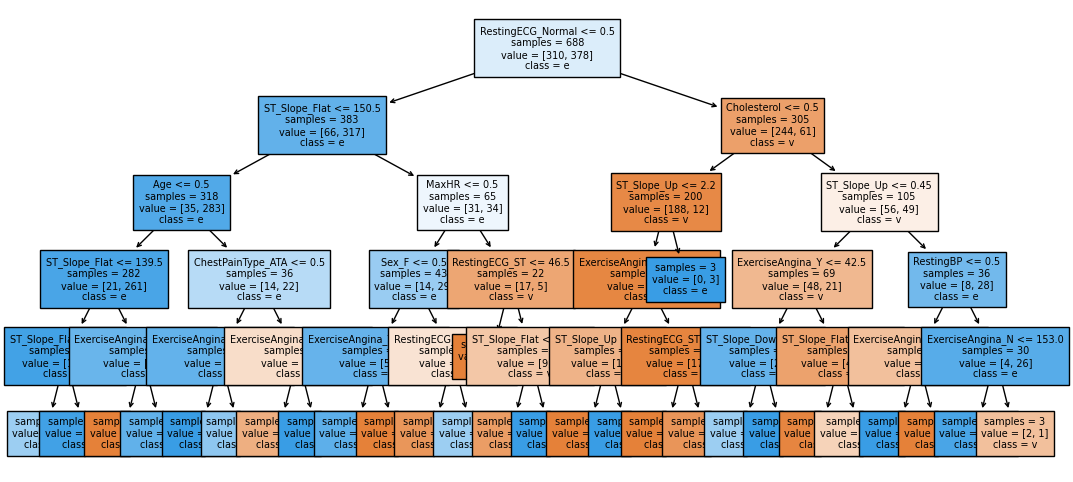

In [25]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

## Predicción y evaluación del modelo

Se evalúa la capacidad predictiva del árbol inicial calculando el accuracy en el conjunto de test.

In [26]:
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[ 81,  19],
       [ 18, 112]], dtype=int64)

In [27]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 83.91304347826087 %


## Podado del árbol (pruning)

Aunque inicialmente se ha empleado un valor de max_depth=5, este no tiene por qué ser el mejor valor. Con el objetivo de identificar la profundidad óptima que consigue reducir la varianza y aumentar la capacidad predictiva del modelo, se somete al árbol a un proceso de pruning.

C:\Users\esnei\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


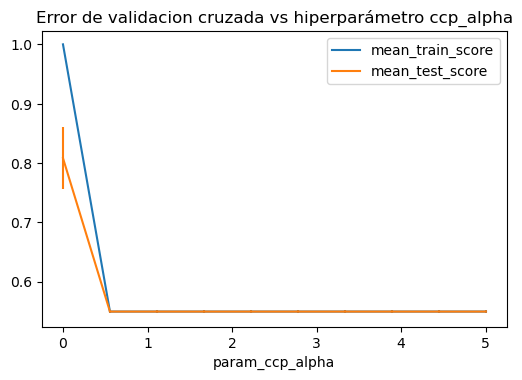

In [28]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train_prep, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [29]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.0}

In [30]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 13
Número de nodos terminales: 99


In [31]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 76.52173913043478 %


## Importancia de predictores

In [32]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': labels.tolist(),
                             'importancia': modelo_final.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
13,RestingECG_Normal,0.392750
18,ST_Slope_Flat,0.115483
19,ST_Slope_Up,0.086734
2,Cholesterol,0.075220
16,ExerciseAngina_Y,0.071958
14,RestingECG_ST,0.070940
15,ExerciseAngina_N,0.058447
17,ST_Slope_Down,0.027477
0,Age,0.023043
4,MaxHR,0.019537


## Predicción de probabilidades

In [33]:
# Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict_proba(X = X_test_prep)
predicciones[:5, :]

array([[0.04035874, 0.95964126],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.04035874, 0.95964126],
       [1.        , 0.        ]])

In [34]:
# Clasificación empleando la clase de mayor probabilidad
# ------------------------------------------------------------------------------
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,0.040359,0.959641,1
1,1.000000,0.000000,0
2,1.000000,0.000000,0


In [35]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ------------------------------------------------------------------------------
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.8, 1, 0)
df_predicciones.iloc[5:10, :]

,0,1,clasificacion_default_0.5,clasificacion_custom_0.8
5,0.861111,0.138889,0,0
6,0.818182,0.181818,0,0
7,0.000000,1.000000,1,1
8,0.166667,0.833333,1,1
9,0.040359,0.959641,1,1
